In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os

In [ ]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive

In [ ]:
from google.colab import files 
  
  
uploaded = files.upload()


Saving day.csv to day.csv


In [ ]:
import pandas as pd 
import io 

In [ ]:
bike_df=pd.read_csv(io.BytesIO(uploaded['day.csv'])) 

In [ ]:
bike_df.shape


(731, 16)

In [ ]:
bike_df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)

In [ ]:
bike_df['datetime']=pd.to_datetime(bike_df.datetime)

bike_df['season']=bike_df.season.astype('category')
bike_df['year']=bike_df.year.astype('category')
bike_df['month']=bike_df.month.astype('category')
bike_df['holiday']=bike_df.holiday.astype('category')
bike_df['weekday']=bike_df.weekday.astype('category')
bike_df['workingday']=bike_df.workingday.astype('category')
bike_df['weather_condition']=bike_df.weather_condition.astype('category')

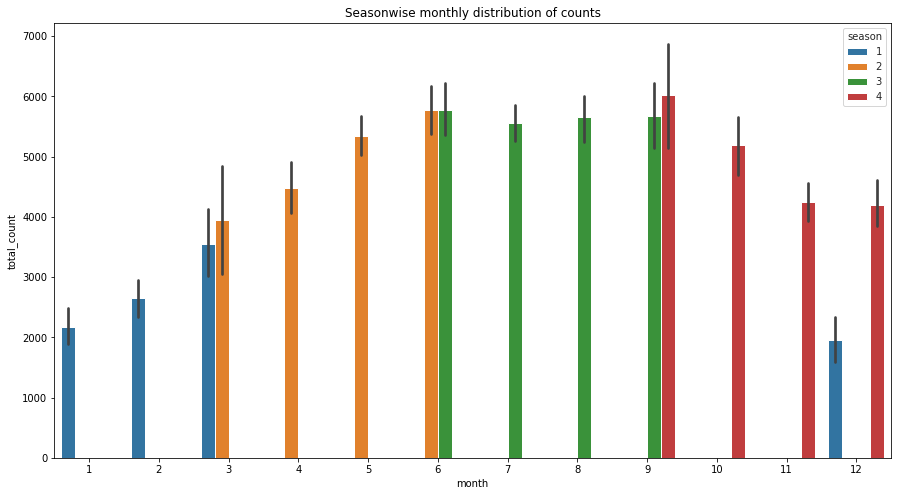

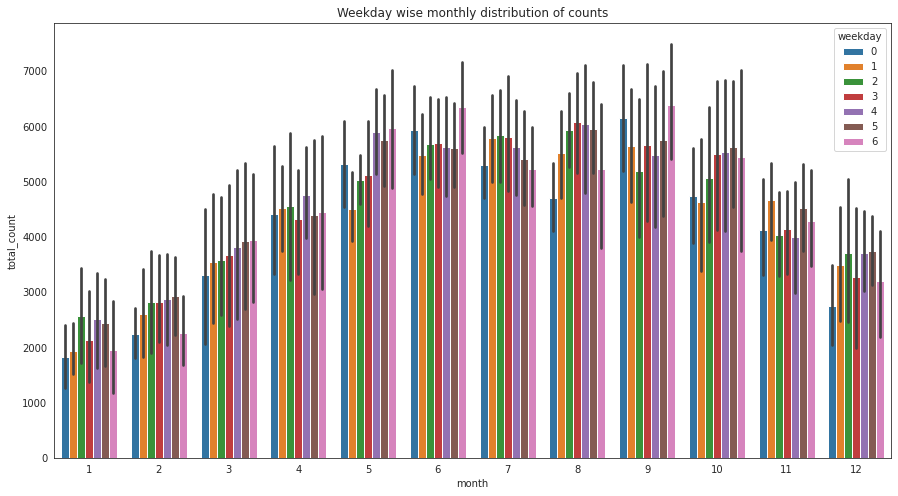

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','weekday']],hue='weekday',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

In [ ]:
from fancyimpute import KNN

#create dataframe for outliers
wind_hum=pd.DataFrame(bike_df,columns=['windspeed','humidity'])
 #Cnames for outliers                     
cnames=['windspeed','humidity']       
                      
for i in cnames:
    q75,q25=np.percentile(wind_hum.loc[:,i],[75,25]) # Divide data into 75%quantile and 25%quantile.
    iqr=q75-q25 #Inter quantile range
    min=q25-(iqr*1.5) #inner fence
    max=q75+(iqr*1.5) #outer fence
    wind_hum.loc[wind_hum.loc[:,i]<min,:i]=np.nan  #Replace with NA
    wind_hum.loc[wind_hum.loc[:,i]>max,:i]=np.nan  #Replace with NA
#Imputating the outliers by mean Imputation
wind_hum['windspeed']=wind_hum['windspeed'].fillna(wind_hum['windspeed'].mean())
wind_hum['humidity']=wind_hum['humidity'].fillna(wind_hum['humidity'].mean())

In [ ]:
bike_df['windspeed']=bike_df['windspeed'].replace(wind_hum['windspeed'])
#Replacing the imputated humidity
bike_df['humidity']=bike_df['humidity'].replace(wind_hum['humidity'])
bike_df.head(5)

,rec_id,datetime,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


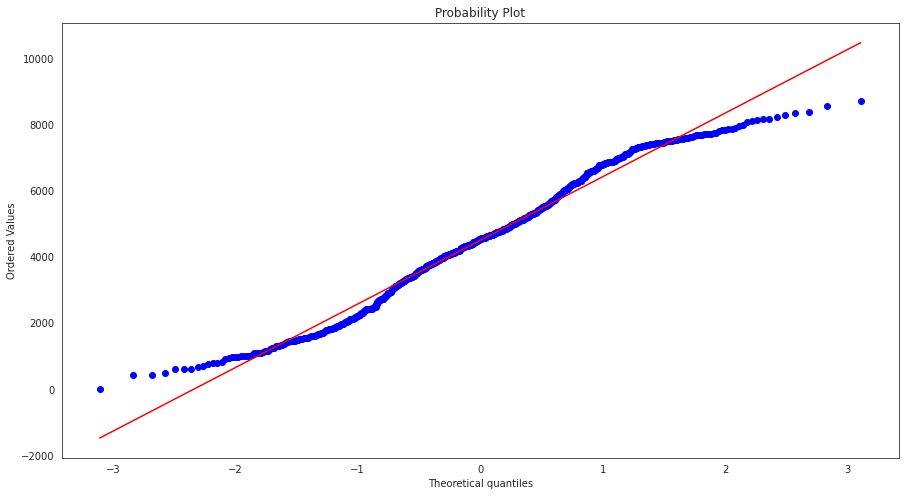

In [ ]:
import scipy
from scipy import stats
#Normal plot
fig=plt.figure(figsize=(15,8))
stats.probplot(bike_df.total_count.tolist(),dist='norm',plot=plt)
plt.show()

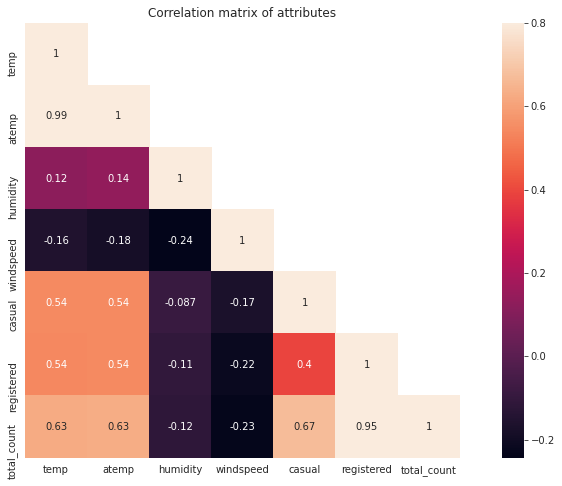

In [ ]:
correMtr=bike_df[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

In [ ]:
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(bike_df.iloc[:,0:-3],bike_df.iloc[:,-1],test_size=0.3, random_state=42)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(y_train.head())
print(y_test.head())

(511, 14) (220, 14) (511, 2) (220, 2)
   index  total_count
0    223         4905
1    684         5445
2    685         5698
3    163         5020
4    394         3624
   index  total_count
0    703         6606
1     33         1550
2    300         3747
3    456         6041
4    633         7538


In [ ]:
train_attributes=X_train[['season','month','year','weekday','holiday','workingday','weather_condition','humidity','temp','windspeed']]
#Create a new dataset for test attributes
test_attributes=X_test[['season','month','year','weekday','holiday','workingday','humidity','temp','windspeed','weather_condition']]
#categorical attributes
cat_attributes=['season','holiday','workingday','weather_condition','year']
#numerical attributes
num_attributes=['temp','windspeed','humidity','month','weekday']

In [ ]:
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
train_encoded_attributes.head(5)

Shape of transfomed dataframe:: (511, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,8,5,0.415000,0.708333,0.125621,0,0,1,0,1,0,0,1,1,0,0,1,0
1,11,4,0.620417,0.321667,0.152987,0,0,0,1,1,0,0,1,0,1,0,0,1
2,11,5,0.524583,0.345000,0.171025,0,0,0,1,1,0,0,1,1,0,0,0,1
3,6,1,0.494583,0.635000,0.305350,0,1,0,0,1,0,0,1,1,0,0,1,0
4,1,1,0.400833,0.269167,0.215792,1,0,0,0,1,0,0,1,1,0,0,0,1


In [ ]:
X_train=train_encoded_attributes
y_train=y_train.total_count.values

In [ ]:
lr_model=linear_model.LinearRegression()
lr_model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',lr_model.coef_)
print('Model intercept value :',lr_model.intercept_)


Accuracy of the model : 0.8165025087335218
Model coefficients : [  -25.40093273    69.00041734 -1021.83801516  5265.83269167
 -2556.15204574  -949.34444399   229.82675107   -79.72789531
   799.24558823   228.48467064  -228.48467064   -78.95445063
    78.95445063   761.85445399   252.23446226 -1014.08891625
  -989.30080604   989.30080604]
Model intercept value : 2195.310562348839


In [ ]:
predict=cross_val_predict(lr_model,X_train,y_train,cv=3)
predict

array([ 5248.7578435 ,  5038.5615668 ,  5806.79339316,  4353.94868702,
        3738.02165465,  6781.13199665,  6258.53686563,  3802.32154757,
        4679.69060739,  3413.26938345,  5382.26926795,  3103.26413427,
        4340.14502978,  5792.02135524,  4357.90482085,  6307.47067538,
        4382.53420011,  3356.51602988,   722.55880035,   542.99629923,
        7419.07107033,  3747.2639444 ,  5282.38323084,  5494.01243603,
        6941.05375802,  7322.95928003,  3629.5886932 ,  3571.12912785,
         985.45343201,  4884.05952005,  1644.73801661,  1708.88196943,
        1689.90104258,  1295.63879625,  4891.47726849,  5507.81236621,
        6015.17425095,  4180.63057735,  5075.38404498,  5941.56769703,
        6400.40498745,  4215.81855312,  5962.38814912,  6052.71452714,
        3345.73314148,  4096.72004817,  1465.44713372,  3603.17274178,
        4587.89942466,  6650.65699064,  1719.93360965,  6128.15135134,
        6439.33525805,  3277.84008997,  4592.0786174 ,  3194.61235   ,
      

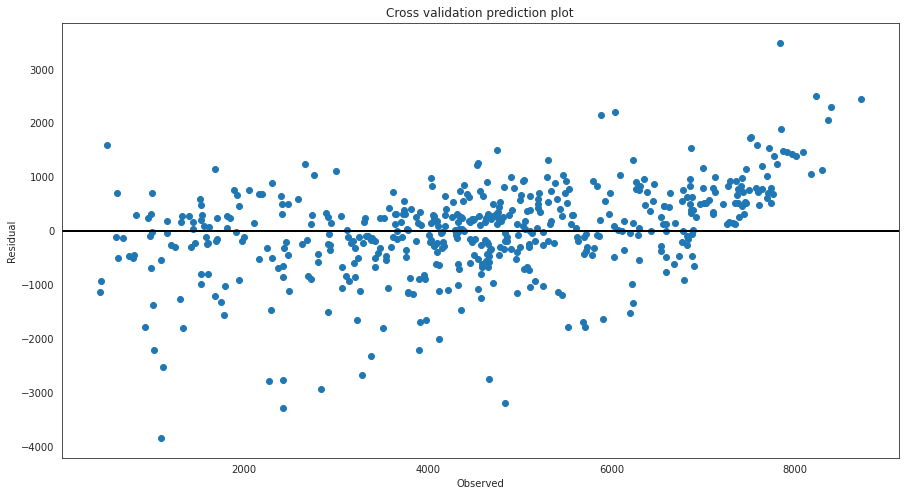

In [ ]:
fig,ax=plt.subplots(figsize=(15,8))
ax.scatter(y_train,y_train-predict)
ax.axhline(lw=2,color='black')
ax.set_title('Cross validation prediction plot')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [ ]:
r2_scores = cross_val_score(lr_model, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.7995611885231044


In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)


In [ ]:
dtr.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dtr_score=dtr.score(X_train,y_train)
print('Accuracy of model :',dtr_score)

Accuracy of model : 0.8082151777539757


In [ ]:
from sklearn.ensemble import RandomForestRegressor
X_train=train_encoded_attributes
rf=RandomForestRegressor(n_estimators=200)

In [ ]:
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.9811127759960613


In [ ]:
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (220, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,12,2,0.733750,0.475833,0.174129,0,0,0,1,1,0,0,1,1,0,0,0,1
1,2,4,0.437826,0.186957,0.277752,1,0,0,0,1,0,0,1,1,0,0,1,0
2,10,5,0.585833,0.330833,0.229479,0,0,0,1,1,0,0,1,0,1,0,1,0
3,4,0,0.676250,0.425833,0.172267,0,1,0,0,1,0,1,0,0,1,0,0,1
4,9,2,0.570000,0.550000,0.236321,0,0,0,1,1,0,0,1,1,0,0,0,1


In [ ]:
X_test=test_encoded_attributes
y_test=y_test.total_count.values

In [ ]:
X_test=test_encoded_attributes
rf_pred=rf.predict(X_test)
rf_pred

array([6618.665, 1548.47 , 3399.365, 4995.335, 7503.37 , 7242.805,
       1491.215, 2211.43 , 7369.65 , 6440.515, 2081.14 , 2990.59 ,
       4940.675, 4940.805, 2126.645, 2140.75 , 2346.915, 7842.595,
       5087.865, 2496.38 , 7462.37 , 6029.145, 5932.13 , 1776.375,
       1742.61 , 4737.165, 1913.165, 7251.395, 3130.255, 5712.105,
       2966.035, 4052.605, 6530.03 , 7350.805, 6132.4  , 5315.32 ,
       7264.34 , 6229.6  , 3220.975,  967.85 , 3831.035, 3181.905,
       7262.725, 4480.025, 6945.185, 2174.42 , 4352.505, 5547.48 ,
       6562.325, 4142.72 , 4189.03 , 2893.165, 2316.145, 4354.41 ,
       4654.705, 4182.435, 3517.11 , 3834.98 , 4220.755, 6587.91 ,
       6163.715, 6783.865, 2005.   , 7324.735, 6434.095, 6381.36 ,
       5922.295, 4338.635, 1822.18 , 7325.17 , 3714.735, 2113.905,
       3269.405, 4023.92 , 4325.1  , 3855.125, 4629.53 , 4466.5  ,
       1371.99 , 4306.145, 2336.67 , 2010.215, 5043.82 , 4147.795,
       3649.62 , 3408.555, 4220.93 , 3740.815, 3474.825, 3380.

In [ ]:
from math import *
import math

In [ ]:
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

Root mean square error : 638.3595565855428
Mean absolute error : 425.1865454545454


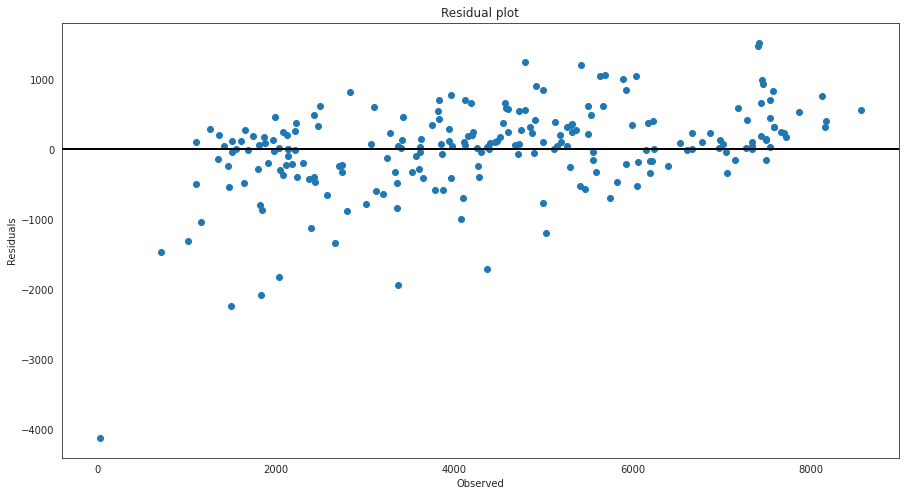

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
residuals=y_test-rf_pred
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.set_title('Residual plot')
plt.show()

In [ ]:
Bike_df1=pd.DataFrame(y_test,columns=['y_test'])
Bike_df2=pd.DataFrame(rf_pred,columns=['rf_pred'])
Bike_predictions=pd.merge(Bike_df1,Bike_df2,left_index=True,right_index=True)
Bike_predictions.to_csv('Bike_Renting_Python.csv')
Bike_predictions

,y_test,rf_pred
0,6606,6618.665
1,1550,1548.470
2,3747,3399.365
3,6041,4995.335
4,7538,7503.370
...,...,...
215,2659,3995.440
216,7338,7226.925
217,6978,6837.920
218,4795,3550.310
